## Download data from kaggle

In [1]:
!kaggle competitions download -c kitchenware-classification
!mkdir data
!unzip kitchenware-classification.zip -d data > /dev/null
!rm kitchenware-classification.zip

100%|█████████████████████████████████████▉| 1.63G/1.63G [00:33<00:00, 80.1MB/s]
100%|██████████████████████████████████████| 1.63G/1.63G [00:33<00:00, 52.9MB/s]
mkdir: cannot create directory ‘data’: File exists
replace data/images/0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
!ls

data				 submission.csv
keras-starter.ipynb		 submission_xception_v1_03_0.898.csv
kitchenware-jupyter-recipe.json  submission_xception_v1_04_0.904.csv
model_v1.h5			 xception_v1_03_0.898.h5
notebook.ipynb			 xception_v1_04_0.904.h5
README.md


## Preparing Data

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import decode_predictions

%matplotlib inline

In [4]:
df_train_full = pd.read_csv('data/train.csv', dtype={'Id': str})
df_train_full['filename'] = 'data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


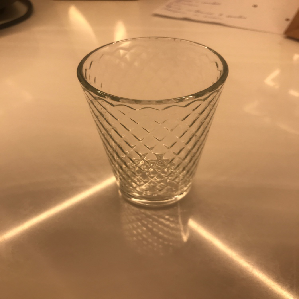

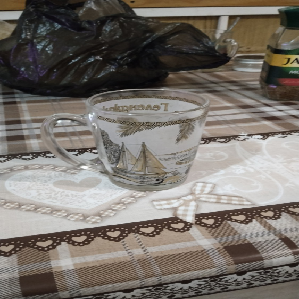

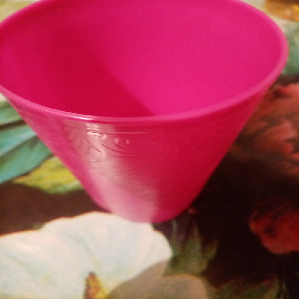

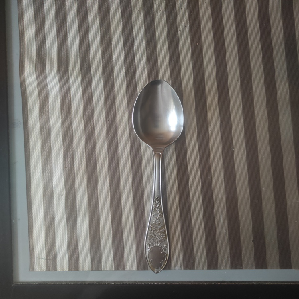

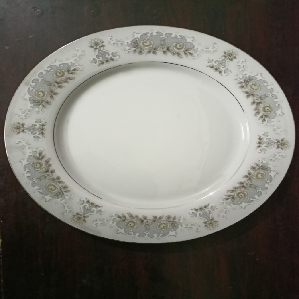

In [8]:
# Samples of images
for i in range(5):
    sample = df_train_full.iloc[i].filename
    img = load_img(sample, target_size=(299, 299))
    img.show()

In [5]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


## Training a baseline model (Pre-trained convolutional neural networks)

In [35]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(6)(vectors)

model = keras.Model(inputs, outputs)

In [36]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [37]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
139/139 [==============================] - 65s 451ms/step - loss: 0.7462 - accuracy: 0.8264 - val_loss: 0.5007 - val_accuracy: 0.8795
Epoch 2/10
139/139 [==============================] - 61s 440ms/step - loss: 0.4253 - accuracy: 0.8930 - val_loss: 0.5976 - val_accuracy: 0.8750
Epoch 3/10
139/139 [==============================] - 62s 443ms/step - loss: 0.2200 - accuracy: 0.9357 - val_loss: 0.6094 - val_accuracy: 0.8732
Epoch 4/10
139/139 [==============================] - 62s 445ms/step - loss: 0.2278 - accuracy: 0.9355 - val_loss: 0.6278 - val_accuracy: 0.8822
Epoch 5/10
139/139 [==============================] - 62s 448ms/step - loss: 0.1404 - accuracy: 0.9541 - val_loss: 0.7442 - val_accuracy: 0.8606
Epoch 6/10
139/139 [==============================] - 62s 443ms/step - loss: 0.1003 - accuracy: 0.9667 - val_loss: 0.6023 - val_accuracy: 0.8795
Epoch 7/10
139/139 [==============================] - 62s 448ms/step - loss: 0.0869 - accuracy: 0.9687 - val_loss: 0.7048 - val_ac

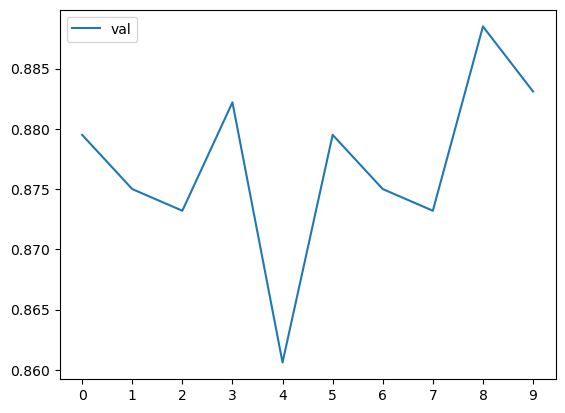

In [41]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [6]:
df_test = pd.read_csv('data/test.csv', dtype={'Id': str})
df_test['filename'] = 'data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


In [44]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 43s 355ms/step


In [10]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [46]:
predictions = classes[y_pred.argmax(axis=1)]
predictions

array(['knife', 'knife', 'knife', ..., 'spoon', 'spoon', 'spoon'],
      dtype='<U5')

In [47]:
# Submit to Kaggle
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
del df_submission['filename']

In [48]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [49]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'validation: 0.8831'

100%|██████████████████████████████████████| 38.9k/38.9k [00:00<00:00, 41.3kB/s]
Successfully submitted to Kitchenware Classification

## Adjusting the learning rate

In [21]:
# Checkpointing
model.save_weights('model_v1.h5', save_format='h5')

In [22]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [60]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [61]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_generator, 
                        epochs=10, 
                        validation_data=val_generator,
                        callbacks=[chechpoint])
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
139/139 [==============================] - 65s 456ms/step - loss: 1.1770 - accuracy: 0.5876 - val_loss: 0.7631 - val_accuracy: 0.7797
Epoch 2/10
139/139 [==============================] - 62s 447ms/step - loss: 0.6261 - accuracy: 0.8230 - val_loss: 0.5422 - val_accuracy: 0.8390
Epoch 3/10
139/139 [==============================] - 62s 445ms/step - loss: 0.4877 - accuracy: 0.8525 - val_loss: 0.4595 - val_accuracy: 0.8570
Epoch 4/10
139/139 [==============================] - 62s 448ms/step - loss: 0.4220 - accuracy: 0.8716 - val_loss: 0.4178 - val_accuracy: 0.8696
Epoch 5/10
139/139 [==============================] - 62s 445ms/step - loss: 0.3831 - accuracy: 0.8797 - val_loss: 0.3890 - val_accuracy: 0.8732
Epoch 6/10
139/139 [==============================] - 63s 452ms/step - loss: 0.3539 - accuracy: 0.8889 - val_loss: 0.3686 - val_accuracy: 0.8786
Epoch 7/10
139/139 [==============================] - 63s 450ms/step - loss: 0.3335 - accuracy: 0.8939 - val_loss: 0.3548 -

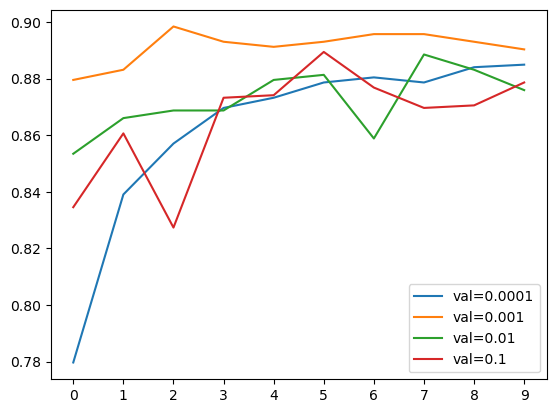

In [62]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [84]:
# Submit to Kaggle
model = keras.models.load_model('xception_v1_03_0.898.h5')

In [87]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 43s 356ms/step


In [88]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [89]:
predictions = classes[y_pred.argmax(axis=1)]
predictions

array(['knife', 'knife', 'knife', ..., 'spoon', 'fork', 'spoon'],
      dtype='<U5')

In [90]:
del df_submission

In [91]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
del df_submission['filename']

In [92]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [93]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'xception_v1_03_0.898.h5'

100%|██████████████████████████████████████| 38.9k/38.9k [00:00<00:00, 50.1kB/s]
Successfully submitted to Kitchenware Classification

## Adding more layers

* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [94]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(6)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [95]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_generator, 
                        epochs=10, 
                        validation_data=val_generator,
                        callbacks=[chechpoint])
    scores[lr] = history.history

    print()
    print()

10
Epoch 1/10
139/139 [==============================] - 65s 451ms/step - loss: 0.5168 - accuracy: 0.8264 - val_loss: 0.3404 - val_accuracy: 0.8714
Epoch 2/10
139/139 [==============================] - 62s 444ms/step - loss: 0.2846 - accuracy: 0.8988 - val_loss: 0.3397 - val_accuracy: 0.8768
Epoch 3/10
139/139 [==============================] - 61s 441ms/step - loss: 0.2270 - accuracy: 0.9217 - val_loss: 0.3132 - val_accuracy: 0.8840
Epoch 4/10
139/139 [==============================] - 62s 444ms/step - loss: 0.1970 - accuracy: 0.9319 - val_loss: 0.2974 - val_accuracy: 0.8957
Epoch 5/10
139/139 [==============================] - 61s 442ms/step - loss: 0.1679 - accuracy: 0.9454 - val_loss: 0.3011 - val_accuracy: 0.8912
Epoch 6/10
139/139 [==============================] - 61s 442ms/step - loss: 0.1430 - accuracy: 0.9550 - val_loss: 0.3032 - val_accuracy: 0.8849
Epoch 7/10
139/139 [==============================] - 61s 442ms/step - loss: 0.1275 - accuracy: 0.9631 - val_loss: 0.3121 - val

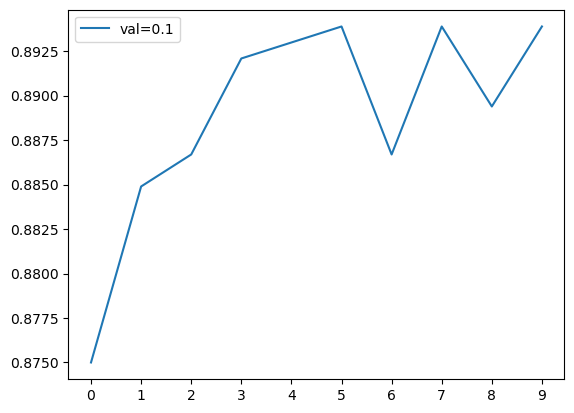

In [98]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
#plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

In [99]:
# Submit to Kaggle
model = keras.models.load_model('xception_v1_04_0.904.h5')

y_pred = model.predict(test_generator)
classes = np.array(list(train_generator.class_indices.keys()))

119/119 [==============================] - 43s 357ms/step


In [100]:
predictions = classes[y_pred.argmax(axis=1)]
predictions

array(['knife', 'knife', 'knife', ..., 'spoon', 'fork', 'spoon'],
      dtype='<U5')

In [101]:
del df_submission
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
del df_submission['filename']

In [102]:
df_submission[['Id', 'label']].to_csv('submission_xception_v1_04_0.904.csv', index=False)

In [104]:
!kaggle competitions submit kitchenware-classification -f submission_xception_v1_04_0.904.csv -m 'xception_v1_04_0.904.h5'

100%|██████████████████████████████████████| 39.0k/39.0k [00:00<00:00, 62.2kB/s]
400 - Bad Request


## Regularization and dropout

* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [13]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [16]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_generator, 
                        epochs=30, 
                        validation_data=val_generator,
                        callbacks=[chechpoint])
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30


2023-01-22 13:49:54.552003: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-22 13:49:55.178151: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:49:55.179053: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:49:55.179088: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-22 13:49:55.180088: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 13:49:55.180190: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 75s 506ms/step - loss: 0.4571 - accuracy: 0.8374 - val_loss: 0.2973 - val_accuracy: 0.8966
Epoch 2/30
139/139 [==============================] - 61s 443ms/step - loss: 0.2328 - accuracy: 0.9136 - val_loss: 0.2944 - val_accuracy: 0.8966
Epoch 3/30
139/139 [==============================] - 61s 439ms/step - loss: 0.1611 - accuracy: 0.9436 - val_loss: 0.3612 - val_accuracy: 0.8732
Epoch 4/30
139/139 [==============================] - 62s 443ms/step - loss: 0.1189 - accuracy: 0.9597 - val_loss: 0.3267 - val_accuracy: 0.8984
Epoch 5/30
139/139 [==============================] - 61s 443ms/step - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.3187 - val_accuracy: 0.9047
Epoch 6/30
139/139 [==============================] - 61s 441ms/step - loss: 0.0539 - accuracy: 0.9843 - val_loss: 0.3467 - val_accuracy: 0.9020
Epoch 7/30
139/139 [==============================] - 61s 441ms/step - loss: 0.0392 - accuracy: 0.9899 - val_loss: 0.3397 - val_accuracy: 0.8

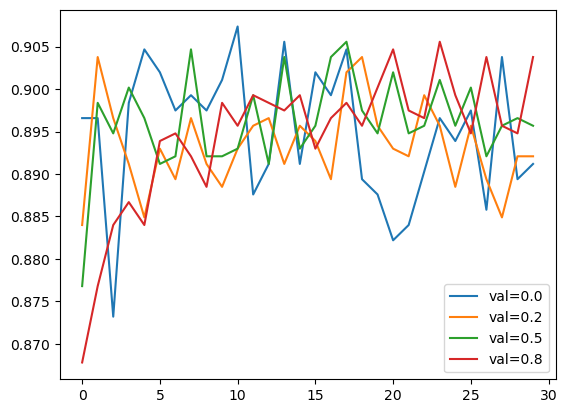

In [17]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

#plt.ylim(0.78, 0.86)
plt.legend()

In [22]:
# Submit to Kaggle
model = keras.models.load_model('xception_v1_11_0.907.h5')

y_pred = model.predict(test_generator)
classes = np.array(list(train_generator.class_indices.keys()))

predictions = classes[y_pred.argmax(axis=1)]

#del df_submission
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('data/images/'):-4]
del df_submission['filename']

df_submission[['Id', 'label']].to_csv('submission_xception_v1_04_0.907.csv', index=False)


119/119 [==============================] - 43s 353ms/step


In [23]:
!kaggle competitions submit kitchenware-classification -f submission_xception_v1_04_0.907.csv -m 'xception_v1_04_0.907.h5'

100%|██████████████████████████████████████| 39.0k/39.0k [00:00<00:00, 41.3kB/s]
Successfully submitted to Kitchenware Classification

## Data augmentation
* Different data augmentations
* Training a model with augmentations
* How to select data augmentations?

In [11]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


In [12]:
def make_model(input_size=299, learning_rate=0.001, size_inner=100, droprate=0.0):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [17]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [23]:
input_size = 299
learning_rate = 0.001
size = 100
droprate = 0.0

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=val_generator,
                    callbacks=[chechpoint])

Epoch 1/50


2023-01-22 16:31:02.353477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-22 16:31:02.990323: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 16:31:02.991230: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 16:31:02.991267: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-22 16:31:02.992344: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-22 16:31:02.992448: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 92s 628ms/step - loss: 0.4712 - accuracy: 0.8338 - val_loss: 0.3056 - val_accuracy: 0.8930
Epoch 2/50
139/139 [==============================] - 78s 563ms/step - loss: 0.2817 - accuracy: 0.8972 - val_loss: 0.2912 - val_accuracy: 0.8912
Epoch 3/50
139/139 [==============================] - 78s 563ms/step - loss: 0.2364 - accuracy: 0.9148 - val_loss: 0.2986 - val_accuracy: 0.8903
Epoch 4/50
139/139 [==============================] - 78s 563ms/step - loss: 0.2025 - accuracy: 0.9253 - val_loss: 0.3583 - val_accuracy: 0.8876
Epoch 5/50
139/139 [==============================] - 78s 564ms/step - loss: 0.1672 - accuracy: 0.9411 - val_loss: 0.3421 - val_accuracy: 0.8966
Epoch 6/50
139/139 [==============================] - 78s 562ms/step - loss: 0.1444 - accuracy: 0.9469 - val_loss: 0.3464 - val_accuracy: 0.8867
Epoch 7/50
139/139 [==============================] - 79s 565ms/step - loss: 0.1261 - accuracy: 0.9562 - val_loss: 0.3540 - val_accuracy: 0.9